# Imports and dataset loading

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.multioutput import MultiOutputRegressor
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
import pandas as pd

strategyArray  = []
gainArray      = []
lossArray      = []
channelTypeQnt = 3
ampNumber      = 4

originalDataSet = []
binaryDataSet   = []

gainScalerList = []
lossScalerList = []

originalDataSet.append(pd.read_csv('../datasets/1_channel_type/dataset-{}.txt'.format(ampNumber), sep = ',',header = None))
originalDataSet.append(pd.read_csv('../datasets/2_channel_type/dataset-{}.txt'.format(ampNumber), sep = ',',header = None))
originalDataSet.append(pd.read_csv('../datasets/4_channel_type/dataset-{}.txt'.format(ampNumber), sep = ',',header = None))

for i in range(channelTypeQnt):
    binaryDataSet.append([])
    for line in originalDataSet[i].values:
        myList = [1 if i != 0 else 0 for i in line[:40]]
        myList.extend(line[40:])
        binaryDataSet[i].append(myList)

    binaryDataSet[i] = pd.DataFrame(binaryDataSet[i])
    gainScaler       = MinMaxScaler(feature_range = (-1, 1))
    lossScaler       = MinMaxScaler(feature_range = (-1, 1))

    gainScalerAux = []
    lossScalerAux = []
    
    for j in range(0, ampNumber * 2, 2):
        gainScalerAux.extend(binaryDataSet[i].values[:, 40 + j])
        lossScalerAux.extend(binaryDataSet[i].values[:, 40 + j + 1])

    gainScaler.fit(np.array(gainScalerAux).reshape(-1, 1))
    lossScaler.fit(np.array(lossScalerAux).reshape(-1, 1))
    
    gainScalerList.append(gainScaler)
    lossScalerList.append(lossScaler)

def loadDataset(channelIndex): 
    dataSet = binaryDataSet[channelIndex].values[:, :40]
    
    for i in range(0, ampNumber * 2, 2):
        gain    = np.array(binaryDataSet[channelIndex].values[:, 40 + i])
        gain    = gainScaler.transform(gain.reshape(-1, 1))
        dataSet = np.hstack((dataSet, gain))
        
        loss    = np.array(binaryDataSet[channelIndex].values[:, 40 + i + 1])
        loss    = lossScaler.transform(loss.reshape(-1, 1))
        dataSet = np.hstack((dataSet, loss))
            
    features, result = np.array(dataSet[:, :40]), np.array(dataSet[:, 40:])
    return features, result

def invertGainNorm(value, channelIndex):
    auxArray = np.array([value, 0, 0, 0, 0, 0]).reshape(-1, 1)
    return gainScalerList[channelIndex].inverse_transform(auxArray)[0][0]

def invertLossNorm(value, channelIndex):
    auxArray = np.array([value, 0, 0, 0, 0, 0]).reshape(-1, 1)
    return lossScalerList[channelIndex].inverse_transform(auxArray)[0][0]
    
def getGainError(value1, value2, channelIndex):
    return abs(invertGainNorm(value1, channelIndex) - invertGainNorm(value2, channelIndex))

def getLossError(value1, value2, channelIndex):
    return abs(invertLossNorm(value1, channelIndex) - invertLossNorm(value2, channelIndex))

features, result = loadDataset(0)

Using TensorFlow backend.


# Cross validation function

In [2]:
def crossValidate(regressor, features, result, folds = 5):
    foldSize   = math.ceil(features.shape[0] / folds)
    gainErrors = []
    lossErrors = []
    
    for i in range(folds): 
        sliceBegin = i * foldSize
        sliceEnd   = (i + 1) * foldSize
        
        X_train = np.delete(features, np.s_[sliceBegin: sliceEnd], 0)
        y_train = np.delete(result, np.s_[sliceBegin: sliceEnd], 0)
        
        if isinstance(regressor, Sequential):
            regressor.fit(X_train, y_train, epochs = 500, verbose = 0)  
        else:
            regressor.fit(X_train, y_train)
            
        X_test = features[sliceBegin: sliceEnd]
        y_test = result[sliceBegin: sliceEnd]
        
        gainError = 0
        lossError = 0
        
        prediction = regressor.predict(X_test)
        
        for predicted, expected in zip(prediction, y_test):
            for i in range(0, ampNumber * 2, 2):
                gainError += getGainError(predicted[i], expected[i], 0) 
                lossError += getLossError(predicted[i + 1], expected[i + 1], 0)
                 
        gainErrors.append((gainError / ampNumber) / foldSize)
        lossErrors.append((lossError / ampNumber) / foldSize) # average loss error by amp
        
    return np.array(gainErrors), np.array(lossErrors)

In [3]:
def trainModel(strategy, channelIndex):   
    features, result       = loadDataset(channelIndex)
    gainErrors, lossErrors = crossValidate(strategy, features, result)

    print(gainErrors, "=> %0.2f (+/- %0.2f)" % (np.mean(gainErrors), gainErrors.std() * 2))
    print(lossErrors, "=> %0.2f (+/- %0.2f)" % (np.mean(lossErrors), lossErrors.std() * 2))
    
    gainArray[channelIndex].append(gainErrors)
    lossArray[channelIndex].append(lossErrors)
    
    return gainErrors, lossErrors

In [4]:
def setANN():
    model = Sequential()
    
    model.add(Dense(4, input_dim = 4, kernel_initializer = 'random_uniform', activation = 'sigmoid'))
    model.add(Dense(8, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(16, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(16, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(32, kernel_initializer = 'normal', activation = 'sigmoid'))  
    model.add(Dense(32, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(64, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(64, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(64, kernel_initializer = 'normal', activation = 'sigmoid')) 
    model.add(Dense(64, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(32, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(32, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(16, kernel_initializer = 'normal', activation = 'sigmoid'))  
    model.add(Dense(16, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(8, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(8, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(4, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(2, kernel_initializer = 'random_uniform', activation = 'relu'))

    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Plotting functions

In [5]:
def plotErrorBoxPlots():
    fig, axis = plt.subplots(2, 3, figsize = (10, 5))
    
    p1 = axis[0, 0].boxplot(gainArray[0])
    axis[0, 0].set_ylabel("Gain Absolute Error (dB)", fontsize = 8)
    axis[0, 0].set_ylim([1, 5])
    
    axis[0, 1].boxplot(gainArray[1])
    axis[0, 1].set_ylim([1, 5])
    #axis[0, 1].get_yaxis().set_visible(False)
    
    axis[0, 2].boxplot(gainArray[2])
    axis[0, 2].set_ylim([1, 5])
    #axis[0, 2].get_yaxis().set_visible(False)
    
    axis[1, 0].boxplot(lossArray[0])
    axis[1, 0].set_ylabel("Loss Absolute Error (dB)", fontsize = 8)
    axis[1, 0].set_xlabel("1 channel type", fontsize = 8)
    axis[1, 0].set_ylim([1, 5])
    
    axis[1, 1].boxplot(lossArray[1])
    axis[1, 1].set_xlabel("2 channel type", fontsize = 8)
    axis[1, 1].set_ylim([1, 5])
    #axis[1, 1].get_yaxis().set_visible(False)
    
    axis[1, 2].boxplot(lossArray[2])
    axis[1, 2].set_xlabel("4 channel type", fontsize = 8)
    axis[1, 2].set_ylim([1, 5])
    #axis[1, 2].get_yaxis().set_visible(False)
    
    fig.suptitle("Train error", fontsize = 16)
    fig.legend(p1["boxes"], strategyArray, handlelength = 0, bbox_to_anchor=(0.7, 0.81), loc = "right")
    
    #fix scale
    
    plt.show()

In [6]:
def plotGainDistribution(regressor):
    return
    features, result = loadDataset(channelIndex)

    predicted = regressor.predict(features)
    fig, axis = plt.subplots(figsize = (10, 5))
    vFunc     = np.vectorize(invertGainNorm)
    
    axis.scatter(vFunc(result[:, 0], 0), vFunc(predicted[:, 0], 0))
    axis.set_title("Gain Distribution")
    axis.set_xlabel("Expected")
    axis.set_ylabel("Predicted")

    plt.show()

In [7]:
def plotLossDistribution(regressor):
    return
    features, result = loadDataset(0)

    predicted = regressor.predict(features)
    fig, axis = plt.subplots(figsize = (10, 5))
    vFunc     = np.vectorize(invertLossNorm)
    
    axis.scatter(vFunc(result[:, 1], 0), vFunc(predicted[:, 1], 0), c = "m")
    axis.set_title("Loss Distribution")
    axis.set_xlabel("Expected")
    axis.set_ylabel("Predicted")

    plt.show()

# Putting all together

In [8]:
gainArray = [[],[],[]]
lossArray = [[],[],[]]

In [9]:
for i in range(channelTypeQnt):
    linearSVR = MultiOutputRegressor(SVR(kernel = "rbf", C = 1.0, gamma = 'scale', epsilon = 0.2))
    trainModel(linearSVR, i)
    
strategyArray.append("1 - SVR (Linear)")
plotGainDistribution(linearSVR)
plotLossDistribution(linearSVR)

[1.62509279 1.50471235 1.94001024 1.86212503 1.52696526] => 1.69 (+/- 0.35)
[2.85936183 2.76586453 1.97144774 1.88607364 1.64583483] => 2.23 (+/- 0.98)
[2.19304812 1.93865609 1.73465462 2.10639161 1.73184843] => 1.94 (+/- 0.38)
[2.54515252 2.14816357 2.10059389 2.55873052 2.4660746 ] => 2.36 (+/- 0.40)
[2.5520245  2.10954668 2.02852863 2.2960509  2.34670521] => 2.27 (+/- 0.37)
[2.20354207 2.24407315 2.27535966 2.52449748 1.98904992] => 2.25 (+/- 0.34)


In [10]:
for i in range(channelTypeQnt):
    lasso = MultiOutputRegressor(linear_model.Lasso(alpha = 0.2))
    trainModel(lasso, i)
    
strategyArray.append("2 - Lasso")
plotGainDistribution(lasso)
plotLossDistribution(lasso)

[2.3316141  2.05579403 2.22312317 2.10437485 1.74994721] => 2.09 (+/- 0.39)
[2.6606353  2.70471449 2.21126541 2.1600231  1.85837188] => 2.32 (+/- 0.64)
[2.08384844 1.93628567 1.61421614 2.21979041 1.68248435] => 1.91 (+/- 0.46)
[2.67199504 2.22815505 2.18923883 2.45692342 2.49914729] => 2.41 (+/- 0.36)
[2.07722876 2.12410943 2.13505897 2.07956252 2.39307262] => 2.16 (+/- 0.24)
[2.41783785 2.28400315 2.37966189 2.62958176 2.00690164] => 2.34 (+/- 0.41)


In [11]:
for i in range(channelTypeQnt):
    lars = MultiOutputRegressor(linear_model.Lars(n_nonzero_coefs=1))
    trainModel(lars, i)
    
strategyArray.append("3 - LARS")
plotGainDistribution(lars)
plotLossDistribution(lars)

[2.24709319 1.94918795 2.21027888 2.08250545 1.64737317] => 2.03 (+/- 0.43)
[2.59923028 2.69266172 2.12531684 2.06818936 1.67775807] => 2.23 (+/- 0.74)
[2.1645718  1.9460953  1.59493255 2.17773034 1.6282444 ] => 1.90 (+/- 0.50)
[2.58652373 2.14618298 2.13262835 2.45663199 2.42700899] => 2.35 (+/- 0.36)
[2.10071511 2.12370213 2.16353903 2.05440857 2.37636996] => 2.16 (+/- 0.22)
[2.3866585  2.26951525 2.30246852 2.60505635 2.04514861] => 2.32 (+/- 0.36)


In [12]:
for i in range(channelTypeQnt):
    huber = MultiOutputRegressor(linear_model.HuberRegressor(max_iter = 10000))
    trainModel(huber, i)
    
strategyArray.append("4 - Huber")
plotGainDistribution(huber)
plotLossDistribution(huber)

[1.95725949 1.55476008 1.96241377 1.91729115 1.65074942] => 1.81 (+/- 0.34)
[3.17621179 2.86221986 1.76302104 1.54821299 1.86322234] => 2.24 (+/- 1.30)
[2.0614365  1.94041859 1.77327372 1.95098703 1.9247668 ] => 1.93 (+/- 0.18)
[2.65716473 2.03120602 2.05033552 2.45903295 2.52021961] => 2.34 (+/- 0.51)
[3.86840904 3.1165178  2.43737684 2.75720741 2.5127243 ] => 2.94 (+/- 1.04)
[3.75820746 2.62097506 3.2738199  2.74711908 2.67115371] => 3.01 (+/- 0.88)


In [13]:
for i in range(channelTypeQnt):
    knn = MultiOutputRegressor(KNeighborsRegressor())
    trainModel(knn, i)
    
strategyArray.append("5 - KNN")
plotGainDistribution(knn)
plotLossDistribution(knn)

[1.6706278  1.60964126 2.19775785 2.04887892 1.64103139] => 1.83 (+/- 0.48)
[2.8157997  3.33240658 1.92056801 1.61080717 2.13071749] => 2.36 (+/- 1.25)
[2.1651087  2.0726087  1.94891304 2.08456522 1.57815217] => 1.97 (+/- 0.42)
[2.5010942  2.08681159 2.0411087  2.70952899 2.27344203] => 2.32 (+/- 0.51)
[2.80833333 1.89896641 2.29450904 2.07719638 2.14173127] => 2.24 (+/- 0.62)
[2.34302756 2.56522825 2.75309216 2.72497847 1.83632214] => 2.44 (+/- 0.67)


In [14]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import ExtraTreeRegressor

for i in range(channelTypeQnt):
    extra_tree = ExtraTreeRegressor(criterion = "mse", random_state=0)
    bret = MultiOutputRegressor(BaggingRegressor(base_estimator = extra_tree, n_estimators = 100, random_state = 0))
    trainModel(bret, i)
    
strategyArray.append("6 - Extra Tree")
plotGainDistribution(bret)
plotLossDistribution(bret)

[1.76764278 1.58457601 2.05159077 1.88993071 1.55916372] => 1.77 (+/- 0.37)
[2.77220616 2.85870015 1.85866404 1.73557874 1.89213749] => 2.22 (+/- 0.97)
[2.08982381 1.93546836 1.77239481 2.06984663 1.57107316] => 1.89 (+/- 0.39)
[2.5146169  2.1666376  2.00052753 2.49583552 2.13043948] => 2.26 (+/- 0.41)
[3.0304771  2.29521402 2.40755486 2.2921194  2.36571955] => 2.48 (+/- 0.56)
[2.23205173 2.25851394 2.28429322 2.43663855 2.14134216] => 2.27 (+/- 0.19)


In [15]:
from sklearn.ensemble import RandomForestRegressor

for i in range(channelTypeQnt):
    randomForest = RandomForestRegressor(max_depth = 8, random_state = 0, n_estimators = 100)
    trainModel(randomForest, i)

strategyArray.append("7 - Random Forest")
plotGainDistribution(randomForest)
plotLossDistribution(randomForest)

[1.76759216 1.57942073 2.04994145 1.89566924 1.55884706] => 1.77 (+/- 0.37)
[2.77208567 2.88297863 1.86136838 1.65916213 1.89260358] => 2.21 (+/- 1.02)
[2.17807577 1.93114278 1.77891446 2.07460795 1.54894064] => 1.90 (+/- 0.44)
[2.52448911 2.17343304 1.98264783 2.51425356 2.0956857 ] => 2.26 (+/- 0.44)
[2.65225039 2.25955487 2.10221859 2.18470704 2.62838394] => 2.37 (+/- 0.46)
[2.24322186 2.2956749  2.29198779 2.40334479 2.0801255 ] => 2.26 (+/- 0.21)


# Plotting error boxplots

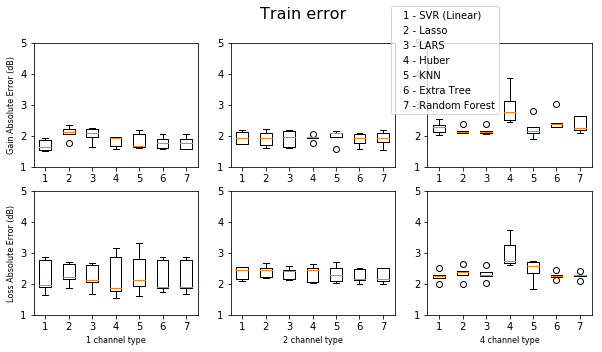

In [16]:
plotErrorBoxPlots()